# Model for risk stratification during pregnance

Goal: we have to build ML model for risk stratification for women during pregnance




# 1. Import dataset and libraries

In [1]:
!pip install phik -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 3.4 MB/s eta 0:00:00


In [3]:
!pip install yellowbrick -q

In [18]:
!pip install shap -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 7.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  LabelEncoder, OneHotEncoder, RobustScaler, StandardScaler, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, f1_score,  roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.inspection import permutation_importance
import lightgbm
from lightgbm import LGBMClassifier
from yellowbrick.classifier.rocauc import roc_auc
from itertools import cycle


In [5]:
from phik import phik_matrix
from phik.report import plot_correlation_matrix
import shap

In [3]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [7]:
def todoplot(df):
    for i in col:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
        ax1.hist(df[i], bins=10);
        ax1.set_title(i)
        ax1.set_ylabel('Количество')
        ax2.boxplot(df[i]);
        ax2.set_title(i)
        plt.show()

In [4]:
data=pd.read_csv('/content/sample_data/Maternal Health Risk Data Set.csv')

# 2. Exploratory data analysis

In [9]:
data.head(5)

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


The dataset has 1014 rows, 7 columns, no gaps in the data

In [11]:
data['RiskLevel'].value_counts()

RiskLevel
low risk     406
mid risk     336
high risk    272
Name: count, dtype: int64

Target attribute - risk level, has 3 gradations from low to high, most rows relate to low risk, least to high, we will take into account the unevenness of groups when dividing the data into training and test samples

In [15]:
data.describe()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
count,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000
mean,29.871795,113.198225,76.460552,8.725986,98.665089,74.301775
std,13.474386,18.403913,13.885796,3.293532,1.371384,8.088702
min,10.000000,70.000000,49.000000,6.000000,98.000000,7.000000
25%,19.000000,100.000000,65.000000,6.900000,98.000000,70.000000
50%,26.000000,120.000000,80.000000,7.500000,98.000000,76.000000
75%,39.000000,120.000000,90.000000,8.000000,98.000000,80.000000
max,70.000000,160.000000,100.000000,19.000000,103.000000,90.000000


When analyzing the statistical distribution of data, we can see that the average age of pregnant women was 29.8 years, average systolic blood pressure 113.2, diastolic 76.4, blood sugar 8.7, temperature 98.6 (Fahrenheit), heart rate 74.3. We also see dates that deviate greatly from normal and are logically unlikely (age 70 years and heart rate 7), it is better to remove these rows.

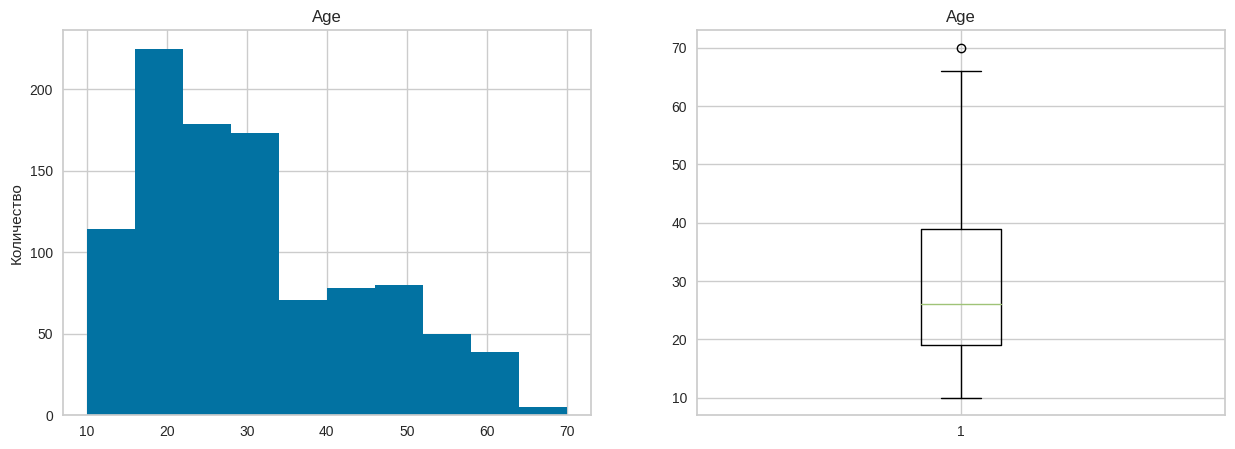

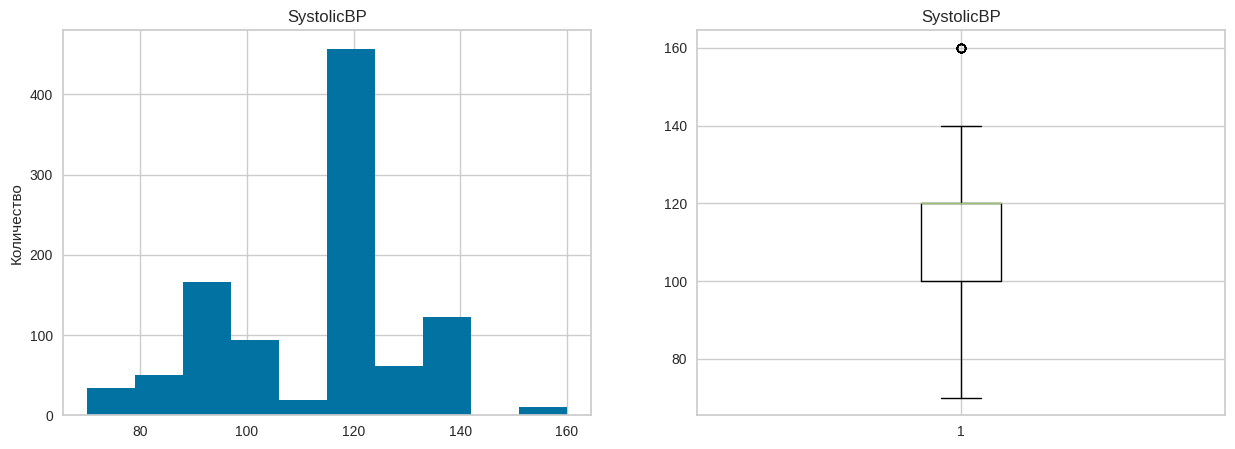

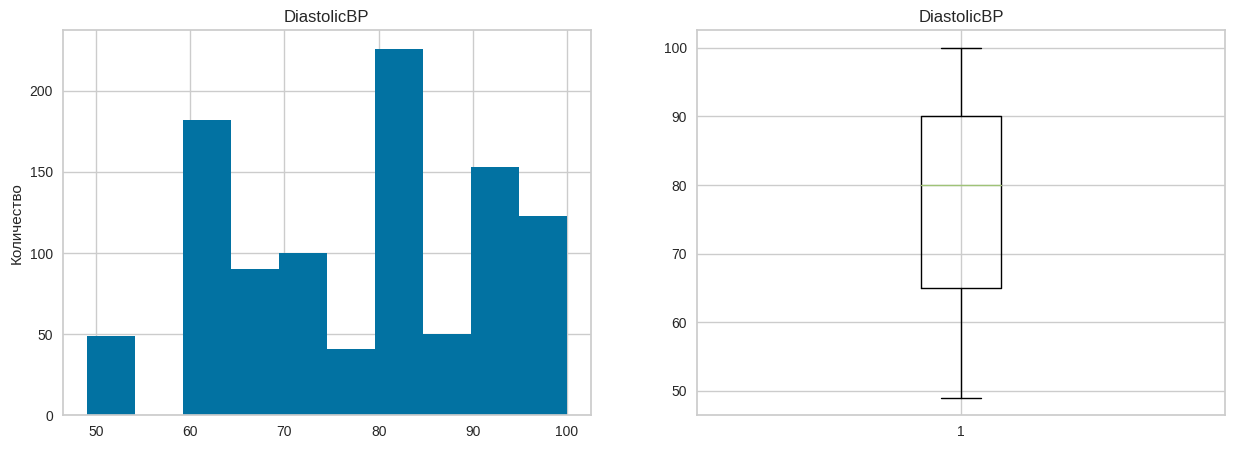

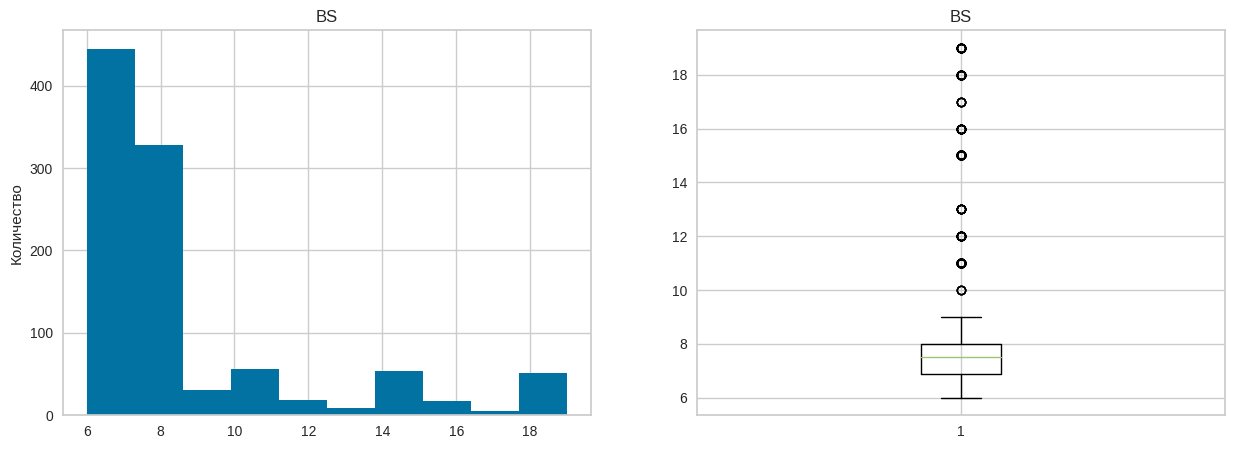

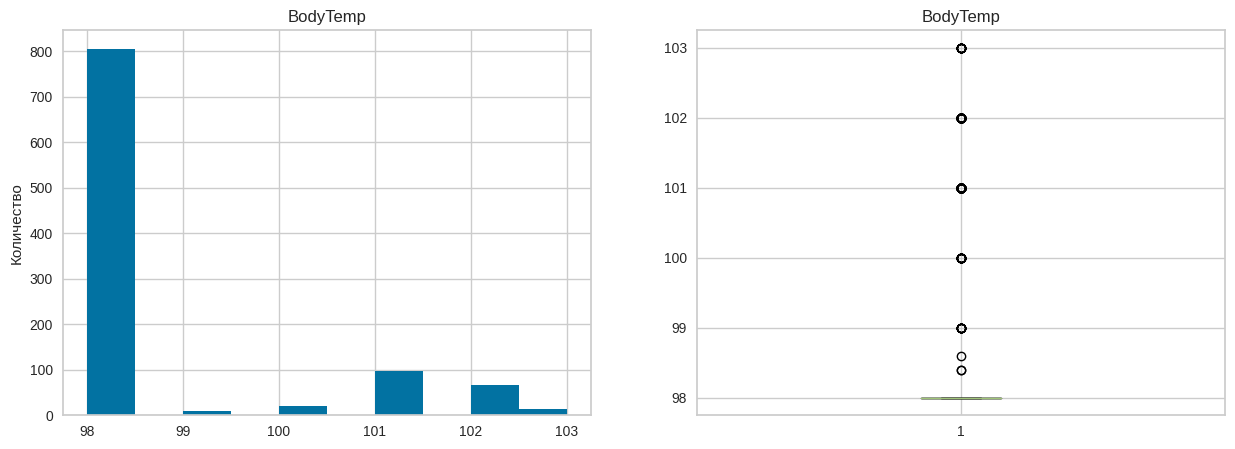

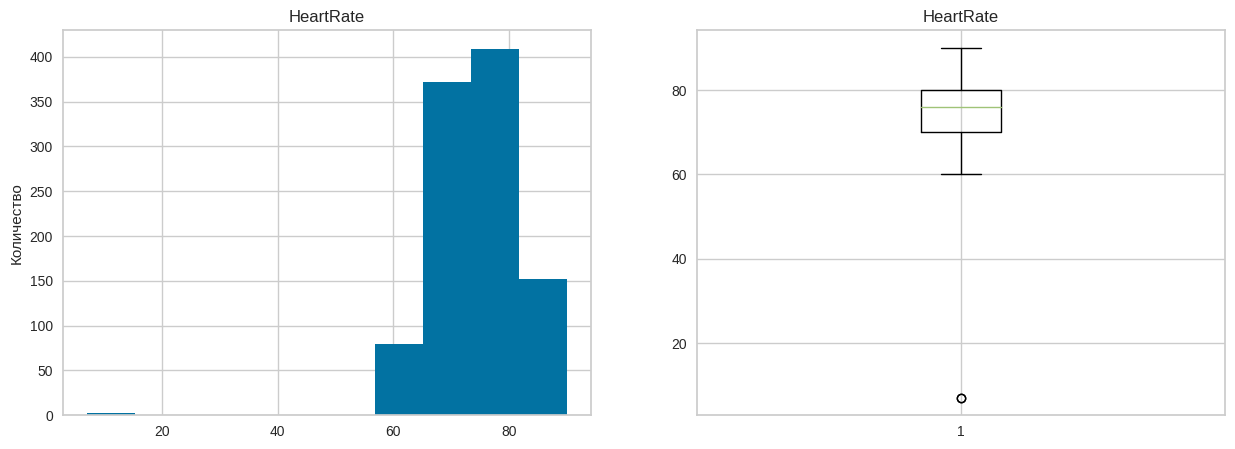

In [16]:
col = ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']
todoplot(data)

In [5]:
data = data.query('HeartRate>8')

In [6]:
data = data.query('Age<60')

In [19]:
interval_cols = ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']
phik_overview = phik_matrix(data, interval_cols=interval_cols)

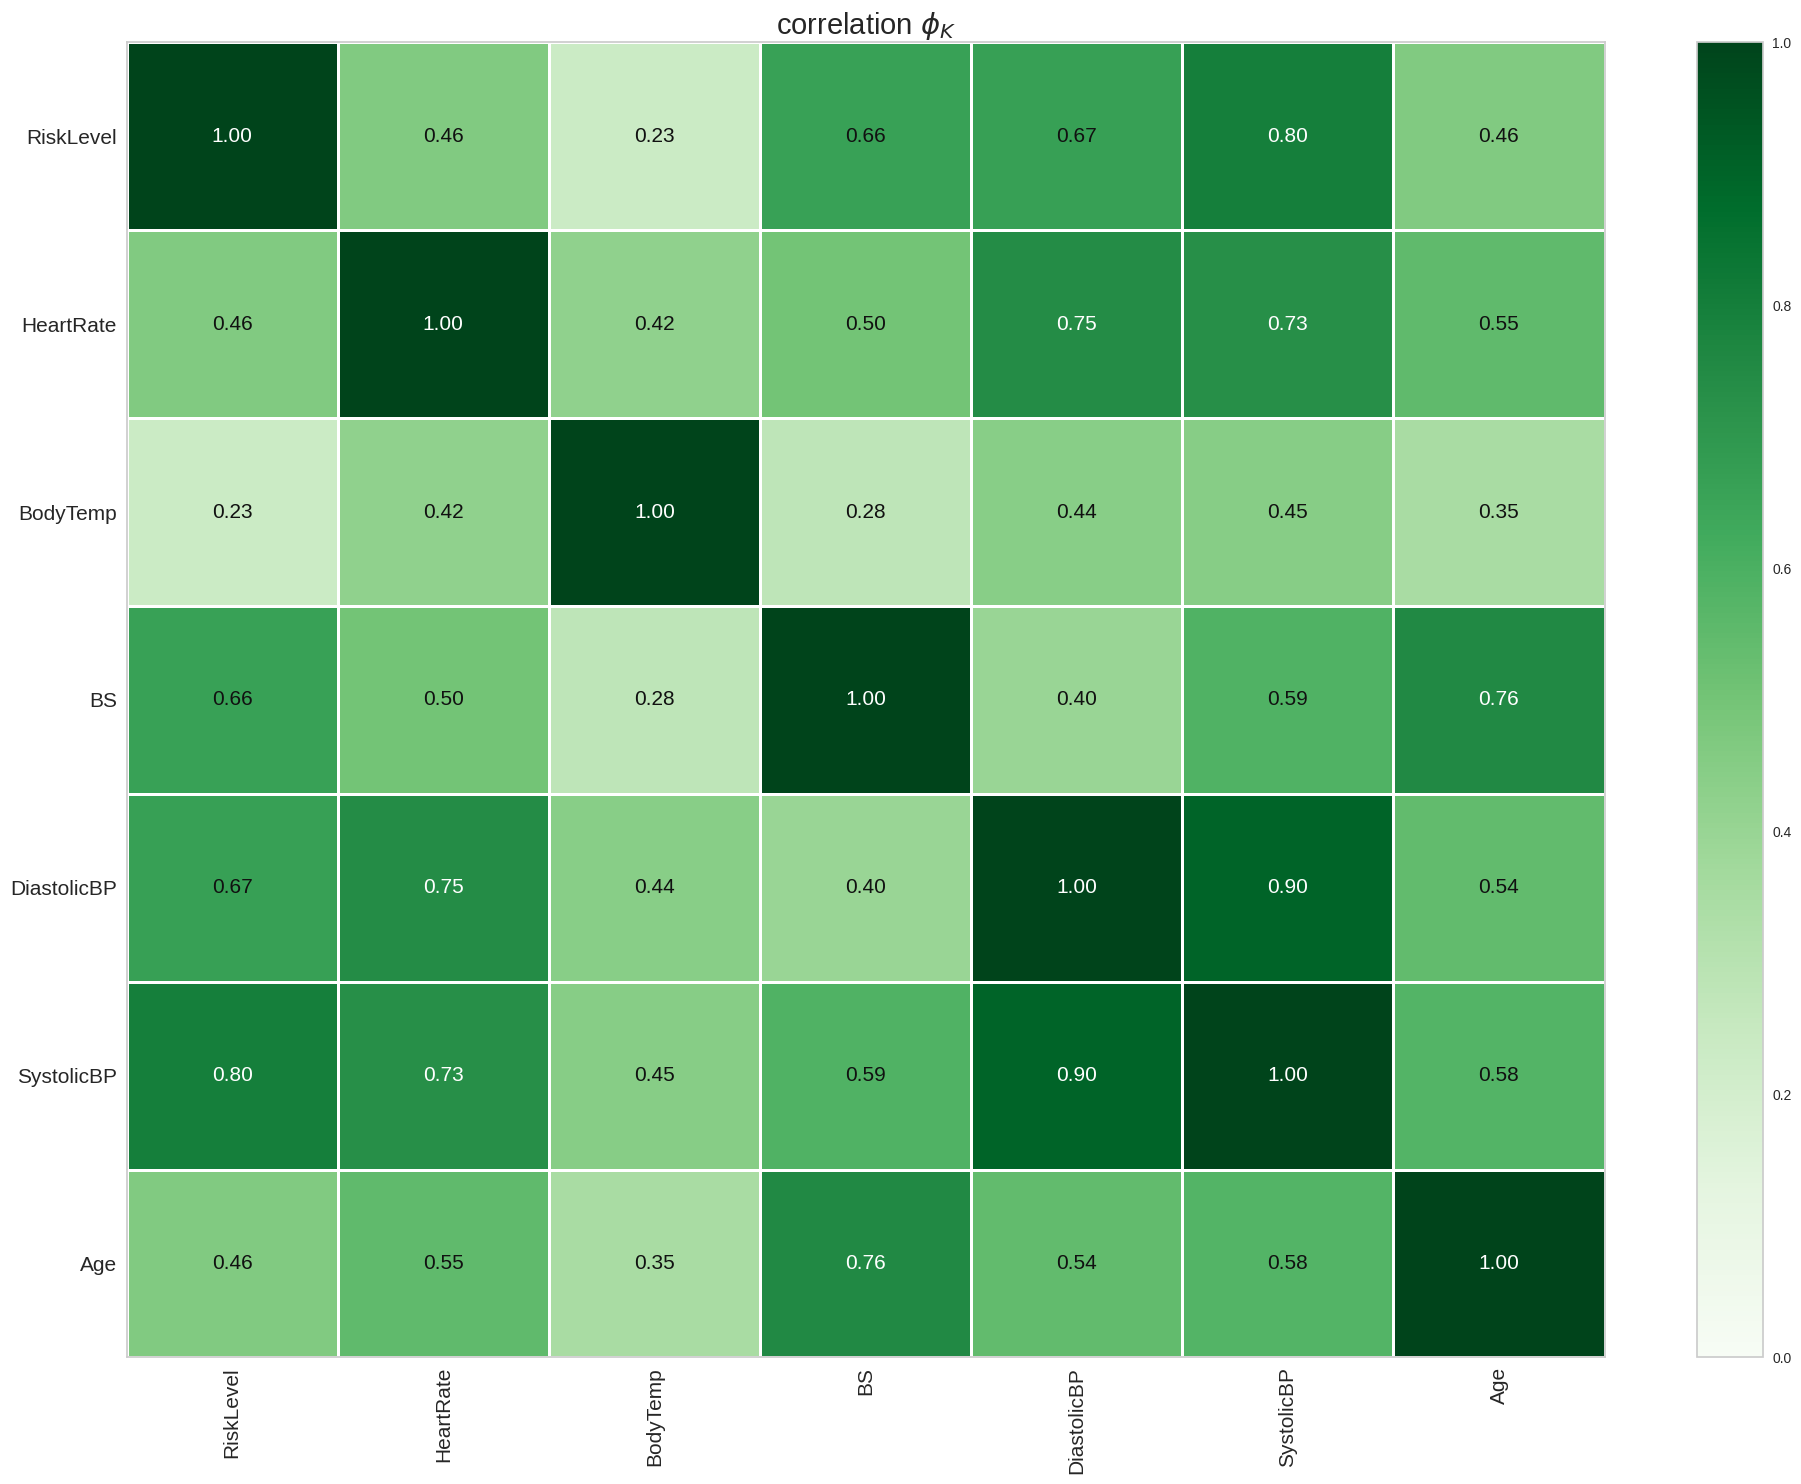

In [20]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

The correlation matrix shows that the level of risk depends most strongly on blood pressure and blood sugar, moderately depends on age and heart rate, and least of all on temperature.

Let's also look at the relationship between systolic pressure and age, as well as between blood sugar levels and age, taking into account the level of risk.

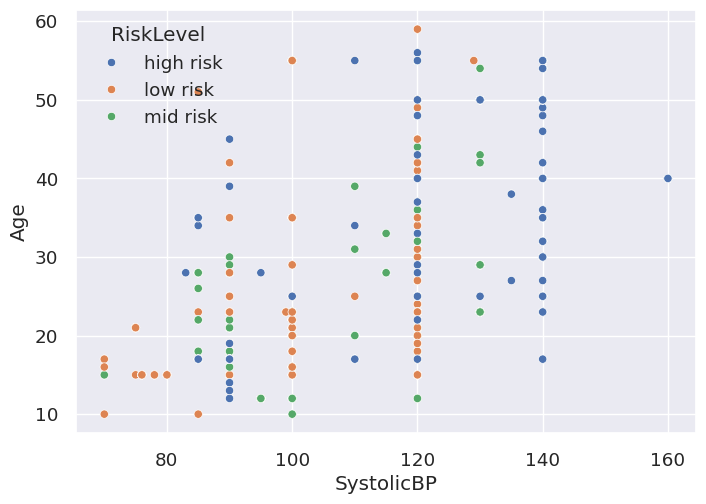

In [ ]:
sns.scatterplot(x='SystolicBP', y='Age', data=data, hue='RiskLevel');

According to the graph, we see that high blood pressure (more than 130) was observed only in pregnant women in the high-risk group, while in young pregnant women (under 20 years old) there was practically no increase in pressure. With low systolic pressure (below 100), we see the opposite picture - it was observed mainly in young people in the low-risk group.

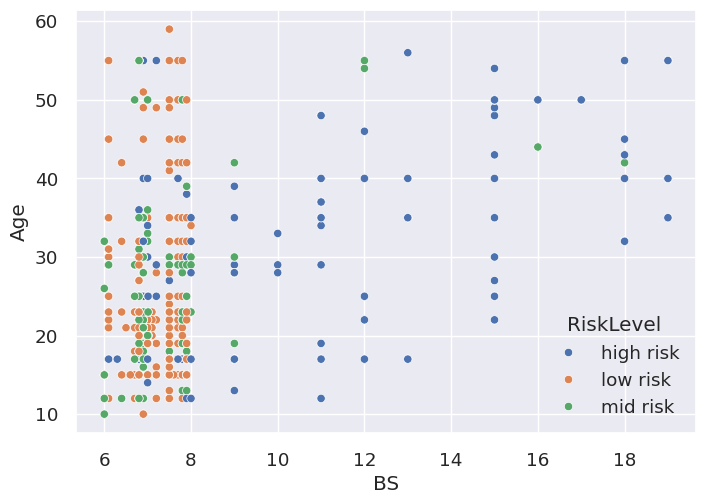

In [ ]:
sns.scatterplot(x='BS', y='Age', data=data, hue='RiskLevel');

In this graph we see that blood sugar levels above 8 are consistently associated with high risk in all age groups; low- and medium-risk pregnant women had sugar levels of 6-8.

In [ ]:
data.query('Age==12')

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
35,12,95,60,6.1,102.0,60,low risk
62,12,95,60,7.2,98.0,77,low risk
82,12,95,60,6.9,98.0,65,mid risk
148,12,95,60,6.7,98.0,77,low risk
155,12,95,60,7.5,98.0,65,low risk
171,12,90,60,7.9,102.0,66,high risk
180,12,95,60,6.1,102.0,60,low risk
244,12,95,60,7.2,98.0,77,low risk
251,12,95,60,6.9,98.0,65,low risk
267,12,90,60,8.0,102.0,66,high risk


When studying data on 12-year-old pregnant women, attention is drawn to the presence of rows with almost the same set of features assigned to opposite risk groups, which will complicate model training and will not allow achieving the highest possible quality of predictions.

# Conclusion from exploratory data analysis:

1. The target feature of the model is qualitative and includes 3 categories; accordingly, we have to solve the problem of multi-class classification.

2. The dataset contains individual outliers that are extremely unlikely in reality (the pregnant woman’s age is 70 years and her heart rate is 7); these rows were removed. In addition to elderly pregnant women, there is data on four 10-year-old pregnant women, which is more likely, so these lines are left. There were no 11-year-olds in the dataset, but there were quite a lot of 12-year-olds. When studying data on 12-year-olds, we noticed the presence of rows with almost the same set of features assigned to opposite risk groups, which will complicate the training of the model and will not allow us to achieve the highest quality of predictions.

3. All features included in the dataset have a high or medium correlation with the target feature.

4. Relationships between systolic blood pressure and age and between blood sugar and age were assessed, adjusting for risk level. It was found that high blood pressure (more than 130) was observed only in pregnant women in the high-risk group, while in young pregnant women (under 20 years old) there was practically no increase in blood pressure. With low systolic pressure (below 100), we see the opposite picture - it was observed mainly in young people in the low-risk group. A blood sugar level above 8 is consistently associated with high risk in all age groups; low- and medium-risk pregnant women had a sugar level of 6-8.



# 3. Machine learning

We will train two models - logistic regression as the base one and compare its results with gradient boosting. As a metric, we use ROC-AUC for multi-class classification as a fairly accurate metric that is independent of the class balance.

The first step is to encode the target feature. Since there are no gaps in the dataset and we don't need all the features except the target numeric continuous Imputer, and we will carry out the standardization using RubustScaler

In [37]:
label_encoder = LabelEncoder()
data['RiskLevel'] = label_encoder.fit_transform(data['RiskLevel'])

In [38]:
label_encoder.classes_

array([0, 1, 2])

In [40]:
X_train_, X_test_, y_train, y_test = train_test_split(
    data.drop(['RiskLevel'], axis=1),
    data['RiskLevel'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify=data['RiskLevel'])

X_train_.shape, X_test_.shape

((727, 6), (243, 6))

In [41]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_)
X_test = scaler.transform(X_test_)


In [42]:
parameters = {
    'C': range(1, 6),
    'class_weight': [None, 'balanced']
}

model= LogisticRegression(random_state=RANDOM_STATE, solver='lbfgs',  multi_class='multinomial', max_iter=1000, penalty='l2')
grid_search = GridSearchCV(estimator=model, param_grid=parameters, cv=5, scoring='f1_macro')

grid_search.fit(X_train, y_train)
print ('The best model and its parameters:\n', grid_search.best_estimator_)
print ('f1 of the best model on cross-validation:', grid_search.best_score_)
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test), multi_class='ovr')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"ROC AUC: {roc_auc}")
print(f"F1 Score: {f1}")

The best model and its parameters:
 LogisticRegression(C=1, max_iter=1000, multi_class='multinomial',
                   random_state=42)
f1 of the best model on cross-validation: 0.618865221857917
ROC AUC: 0.8001168567444293
F1 Score: 0.5890589510928494


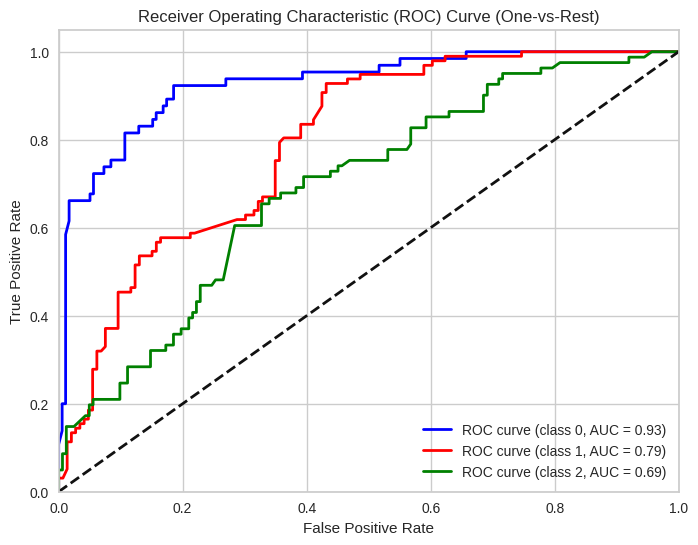

In [44]:
y_bin = label_binarize(y_test, classes=np.unique(y_test))

classifier = OneVsRestClassifier(LogisticRegression(solver='lbfgs', multi_class='ovr'))
classifier.fit(X_train, y_train)

y_score = classifier.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(np.unique(y_test))):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green']  # Указать нужное количество цветов для классов
for i, color in zip(range(len(np.unique(y_test))), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve (class {i}, AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [43]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.68      0.75        65
           1       0.58      0.76      0.66        97
           2       0.42      0.32      0.36        81

    accuracy                           0.59       243
   macro avg       0.61      0.59      0.59       243
weighted avg       0.59      0.59      0.58       243



According to classification_report we can say that Logistic regression shows  predictive ability only for high risk, somewhat worse for low risk, and very weak for medium risk.

In [44]:
parameters={'model__n_estimators': [150, 200, 300],
            'model__num_leaves':[10, 20, 30],
            'model__learning_rate':[0.1, 0.01, 0.5],
            'model__min_child_samples':[20, 40, 60],
            'model__max_depth':[10, 15, 20]
}
model= LGBMClassifier(random_state=RANDOM_STATE, verbose=-1)

gs_lgb = GridSearchCV(estimator=model, param_grid=parameters, cv=5, scoring='f1_macro')

gs_lgb.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=42, verbose=-1),
             param_grid={'model__learning_rate': [0.1, 0.01, 0.5],
                         'model__max_depth': [10, 15, 20],
                         'model__min_child_samples': [20, 40, 60],
                         'model__n_estimators': [150, 200, 300],
                         'model__num_leaves': [10, 20, 30]},
             scoring='f1_macro')

In [45]:
print ('The best model and its parameters:\n', gs_lgb.best_estimator_)
print ('f1 of the best model on cross-validation:', gs_lgb.best_score_)
best_model = gs_lgb.best_estimator_

y_pred = best_model.predict(X_test)
roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test), multi_class='ovr')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"ROC AUC: {roc_auc}")
print(f"F1 Score: {f1}")

The best model and its parameters:
 LGBMClassifier(model__learning_rate=0.1, model__max_depth=10,
               model__min_child_samples=20, model__n_estimators=150,
               model__num_leaves=10, random_state=42, verbose=-1)
f1 of the best model on cross-validation: 0.8101800431734976
ROC AUC: 0.9378978101521035
F1 Score: 0.826354038118744


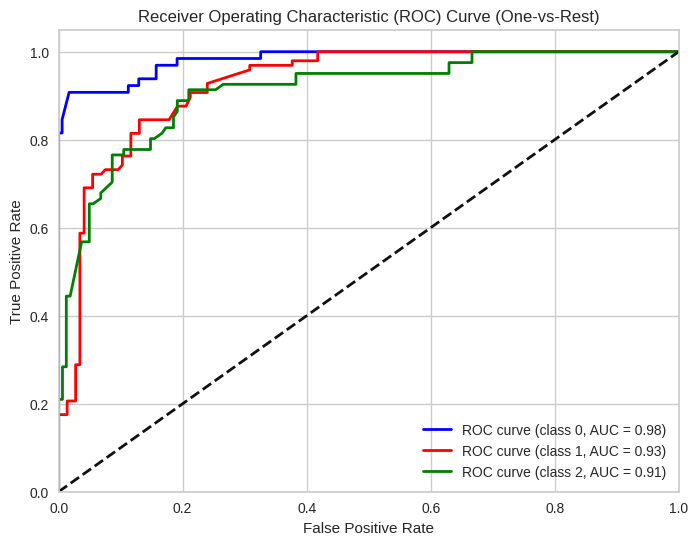

In [15]:
y_bin = label_binarize(y_test, classes=np.unique(y_test))

y_score = gs_lgb.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(np.unique(y_test))):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green']
for i, color in zip(range(len(np.unique(y_test))), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve (class {i}, AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

The performance of gradient boosting is significantly higher than that of regression, and for the high class the accuracy is close to 100%, but for the other two classes it is quite high.


PermutationExplainer explainer: 244it [04:03,  1.04s/it]


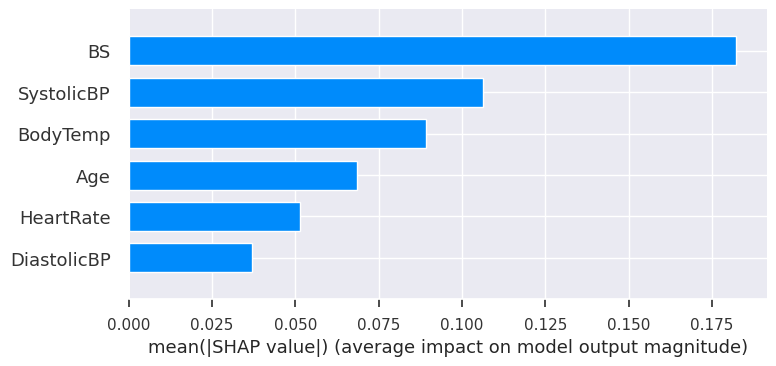

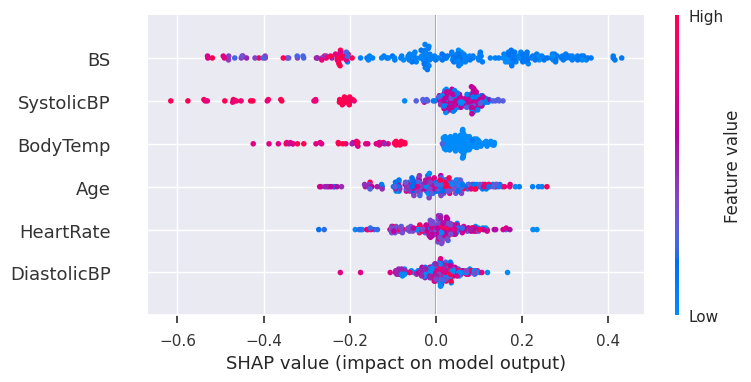

In [46]:
explainer = shap.PermutationExplainer(gs_lgb.best_estimator_.predict_proba, X_test)
feature_names = X_train_.columns
explainer.feature_names = feature_names
shap_values_ = explainer(X_test)
shap.summary_plot(shap_values_[:,:,1], X_test, feature_names=feature_names, max_display=15, plot_type='bar')



shap.plots.beeswarm(shap_values_[:,:,1], max_display=30)

In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91        65
           1       0.82      0.77      0.79        97
           2       0.73      0.78      0.75        81

    accuracy                           0.81       243
   macro avg       0.82      0.82      0.82       243
weighted avg       0.81      0.81      0.81       243



<Figure size 1000x800 with 0 Axes>

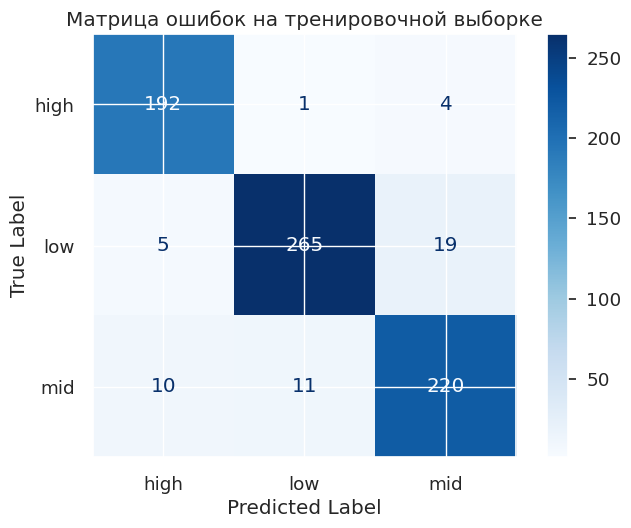

In [66]:
y_pred = best_model.predict(X_train)

conf_matrix = confusion_matrix(y_train, y_pred)
class_names = ['high', 'low', 'mid']

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap='Blues')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Матрица ошибок на тренировочной выборке')

plt.show()

On the training set, the error matrix shows that only in 1 case the model classified a high-risk pregnant woman as low, in 4 cases as medium, the most errors were in distinguishing between low and medium risk.

<Figure size 1000x800 with 0 Axes>

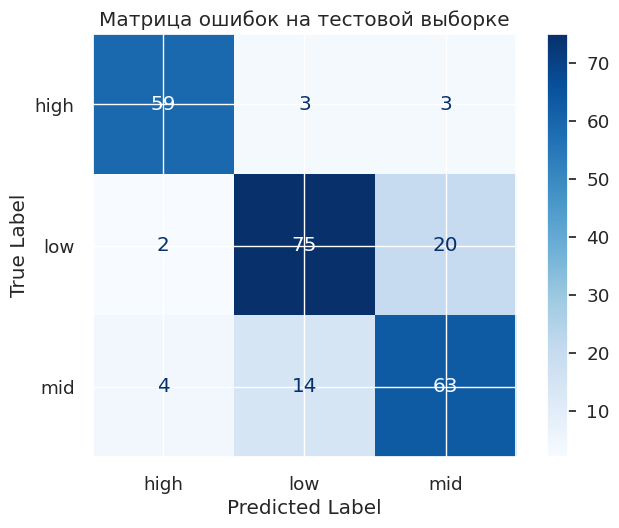

In [17]:
y_pred = best_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
class_names = ['high','low','mid']
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)

disp.plot(cmap='Blues')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Матрица ошибок на тестовой выборке')

plt.show();


In the test sample, the model predicted a low risk for three high-risk pregnant women, and an average risk was predicted for three more high-risk pregnant women. There are also isolated reverse errors - high risk was predicted for two low-risk and four medium-risk pregnant women. Most errors are in the distribution between medium and low risk.

# General conclusion about the project

1. Data and libraries have been imported.

2. An exploratory data analysis was carried out and conclusions were drawn:
  The dataset contains individual outliers that are extremely unlikely in reality (the pregnant woman's age is 70 years and her heart rate is 7); these rows were removed. In addition to elderly pregnant women, there is data on four 10-year-old pregnant women, which is more likely, so these lines are left. There were no 11-year-olds in the dataset, but there were quite a lot of 12-year-olds. When studying data on 12-year-olds, was noticed the presence of rows with almost the same set of features assigned to opposite risk groups, which will complicate the training of the model and will not allow us to achieve the highest quality of predictions.

  All features included in the dataset have a high or medium correlation with the target feature.
  Relationships between systolic blood pressure and age and between blood sugar and age were assessed, adjusting for risk level. It was found that high blood pressure (more than 130) was observed only in pregnant women in the high-risk group, while in young pregnant women (under 20 years old) there was practically no increase in blood pressure.
  With low systolic pressure (below 100), we see the opposite picture - it was observed mainly in young people in the low-risk group. A blood sugar level above 8 is consistently associated with high risk in all age groups; low- and medium-risk pregnant women had a sugar level of 6-8.

3. Two models were trained - logistic regression and gradient boosting for multi-class classification, ROC-AUC was selected as the metric.
Model training results: Logistic regression shows good predictive ability for high risk (metric 0.87), somewhat worse for low risk (0.73) and weak for medium risk (0.65).
The performance of gradient boosting is significantly higher than that of regression, and for the high class the accuracy is close to 100% (0.98), but for the other two classes it is quite high (low risk 0.93, medium risk 0.90).

4. Using the shap method, the weights of the features assigned to them by the model are estimated and displayed graphically in descending order. All signs had a positive weight, the most significant levels were blood sugar, systolic pressure followed by body temperature  age, heart rate and diastolic pressure.

5. Error matrices for gradient boosting were constructed for training and test samples. On the training set, the error matrix shows that only in 1 case the model classified a high-risk pregnant woman as low, in 4 cases as medium, the most errors were in distinguishing between low and medium risk.
  On the test sample, the model predicted low risk for three high-risk pregnant women, and medium risk was predicted for another three high-risk pregnant women. There are also isolated reverse errors - high risk was predicted for two low-risk and four medium-risk pregnant women. Most errors are in the distribution between medium and low risk.

  Since from a clinical point of view it is more important not to miss high-risk pregnant women, you can shift the classification threshold to improve the recall metric, however, an experiment with this dataset showed that the false-negative high risk becomes zero only at a threshold above 0.8, which leads to the appearance of a large number of false-positive cases high risk and excessive therapeutic interventions, incl. unjustified premature births.
  Considering the above, I think it is more reasonable to improve the quality of predictions by expanding the dataset both in the number of rows and by adding other potentially important signs (for example, protein in the urine, neurological symptoms).
